In [1]:
import sys
sys.path.insert(0, "..")
from tensorflow import keras
from kdg.utils import generate_ellipse as generate_data
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.io import savemat, loadmat

from kdn_versions.kdn_all_w_apprx_lin_npar import kdn as kdn1
from kdn_versions.kdn_all_w_strict_lin_npar import kdn_all_w as kdn2
from kdn_versions.kdn_all_w_meta_poly_npar import kdn_all_w_meta_poly as kdn3

In [42]:
# select the KDN to run the experiments
selectKDN = 1 # 1: KDN approx lin, 2: KDN strict lin, 3: KDN meta poly

kdn_versions = [
    "KDN_approx_lin",
    "KDN_strict_lin",
    "KDN_meta_poly"
]

# kdn approx lin
kdn1_kwargs = {
    "k": 1e-5,
    "polytope_compute_method": "all",
    "weighting_method": "lin",
    "T": 2,
    "c": 3,
    "verbose": False
}

# kdn strict lin
kdn2_kwargs = {
    "k": 1e-7,
    "polytope_compute_method": "all",
    "weighting_method": "lin",
    "T": 2,
    "c": 1,
    "verbose": False
}

# kdn meta poly
kdn3_kwargs = {
    "k": 1e-5,
    "polytope_compute_method": "all",
    "weighting_method": "lin",
    "T": 2,
    "c": 2,
    "verbose": False
}

### Visualize the Class Posteriors and Likelihoods

In [43]:
X, y = generate_data(10000)
X_val, y_val = generate_data(500)
X_test, y_test = generate_data(1000)

In [44]:
# Define NN parameters
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=False)
fit_kwargs = {
    "epochs": 300,
    "batch_size": 64,
    "verbose": False,
    "validation_data": (X_val, keras.utils.to_categorical(y_val)),
    "callbacks": [callback],
}

In [45]:
# network architecture [10, 10, 10, 10, 2]
def getNN():
    network_base = keras.Sequential()
    initializer = keras.initializers.GlorotNormal(seed=0)
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer, input_shape=(2,)))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(units=2, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [46]:
# train Vanilla NN
nn = getNN()
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

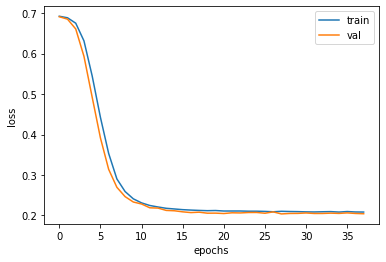

In [47]:
# plot the training loss and validation loss
fig, ax = plt.subplots()
ax.plot(history.history["loss"])
ax.plot(history.history["val_loss"])
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend(["train", "val"])

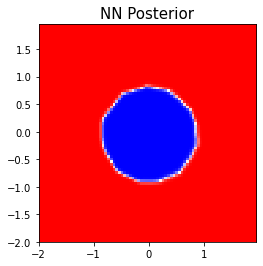

In [48]:
# plot the NN class posteriors
p = np.arange(-2, 2, step=0.05)
q = np.arange(-2, 2, step=0.05)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

proba_nn = nn.predict(grid_samples)

fig, ax = plt.subplots()
ax1 = ax.imshow(
        proba_nn[:, 0].reshape(80, 80).T,
        extent=[xx.min(), xx.max(), yy.min(), yy.max()],
        cmap="bwr",
        vmin=0,
        vmax=1,
        interpolation="nearest",
        aspect="auto",
    )
ax.set_title("NN Posterior", fontsize=15)
ax.set_aspect("equal")

In [49]:
# train the KDN
if selectKDN == 1:
    model_kdn = kdn1(nn, **kdn1_kwargs)
if selectKDN == 2:
    model_kdn = kdn2(nn, **kdn2_kwargs)
if selectKDN == 3:
    model_kdn = kdn3(nn, **kdn3_kwargs)
model_kdn.fit(X, y)

In [50]:
# define the grid
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

In [51]:
# compute metrics (accuracy, class posteriors and likelihood over the grid)
df = {}
nn_accuracy = np.mean(np.argmax(nn.predict(X_test), axis=1) == y_test)
proba_nn = nn.predict(grid_samples)
df["nn_acc"] = nn_accuracy
df["nn_proba"] = proba_nn

kdn_accuracy = np.mean(model_kdn.predict(X_test)==y_test)
proba_kdn, likelihoods = model_kdn.predict_proba(grid_samples, return_likelihoods=True)

df["kdn_acc"] = kdn_accuracy
df["kdn_proba"] = proba_kdn
df["kdn_lh"] = likelihoods

#### Class Posterior Probabilities

In [52]:
# get true posterior
tp_df = pd.read_csv("tp.csv")
proba_true = 0.5*np.ones((400, 400))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true[100:300, 100:300] = tmp
df["true_proba"] = proba_true

In [53]:
# get NN and KDN posteriors
proba_nn = np.flip(df["nn_proba"][:, 0].reshape(400, 400), axis=1)
proba_kdn = np.flip(df["kdn_proba"][:, 0].reshape(400, 400), axis=1)

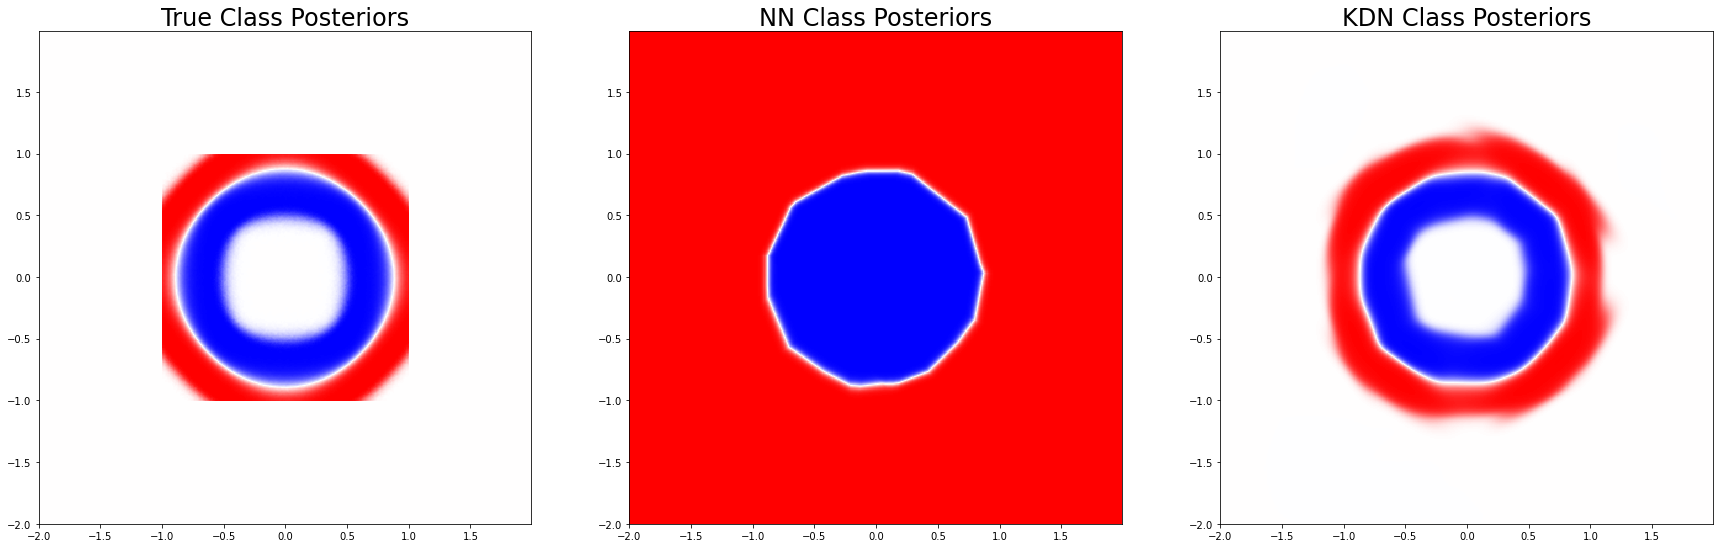

In [54]:
fig1, ax = plt.subplots(1, 3, figsize=(30, 90))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    proba_nn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("NN Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")
# fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)

ax2 = ax[2].imshow(
    proba_kdn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")
# fig.colorbar(ax2, ax=ax[2], fraction=0.046, pad=0.04)

# fig.savefig("KDN_one_gaussian_per_polytope.pdf", bbox_inches='tight')
plt.show()


#### Class Likelihoods

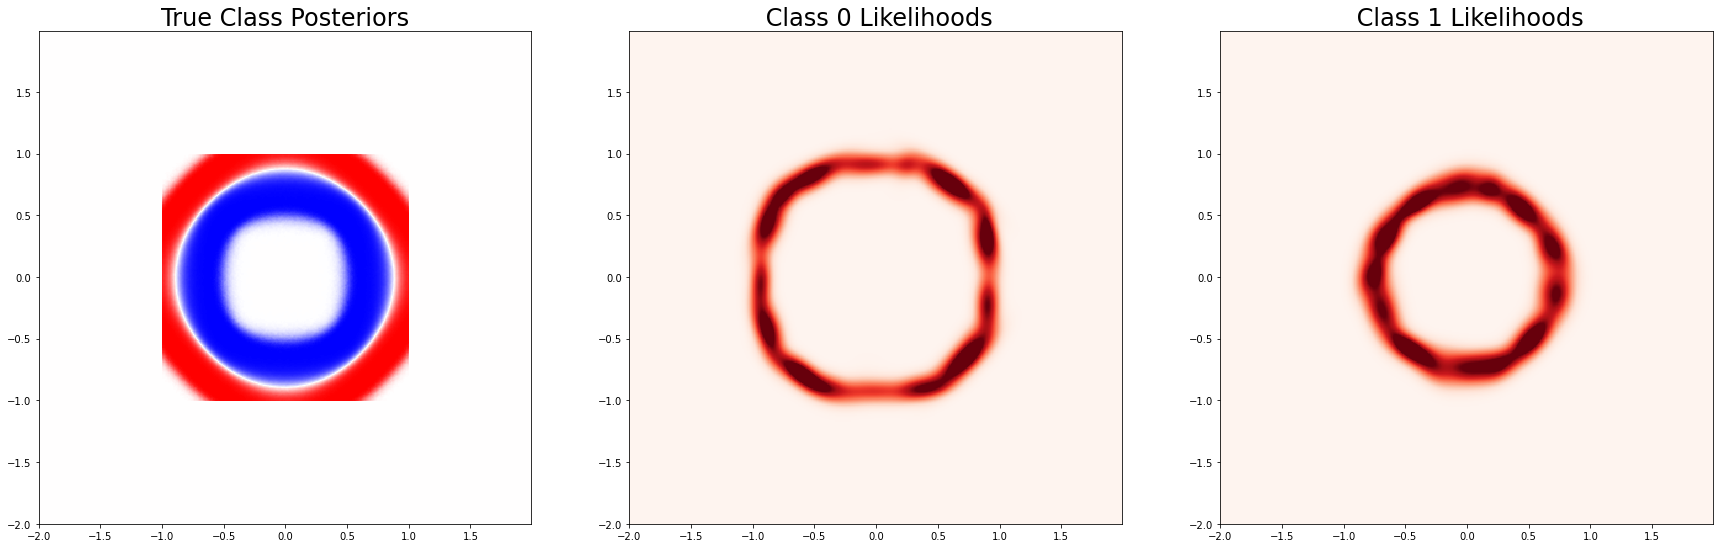

In [55]:
fig2, ax = plt.subplots(1, 3, figsize=(30, 30))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    np.flip(df["kdn_lh"][:, 0].reshape(400, 400), axis=1),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title(" Class 0 Likelihoods", fontsize=24)
ax[1].set_aspect("equal")
# fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)

ax2 = ax[2].imshow(
    np.flip(df["kdn_lh"][:, 1].reshape(400, 400), axis=1),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title(" Class 1 Likelihoods", fontsize=24)
ax[2].set_aspect("equal")
# fig.colorbar(ax2, ax=ax[2], fraction=0.046, pad=0.04)


### Curves with Varying Sample Sizes

In [56]:
# create out-of-distribution samples
def generate_ood_samples(n, inbound=[1, -1], outbound=[5, -5]):
    Xood = []
    i = 0
    while True:
        x1 = (outbound[0] - outbound[1])*np.random.random_sample() - outbound[0]
        x2 = (outbound[0] - outbound[1])*np.random.random_sample() - outbound[0]
        if (-inbound[0] < x1 < inbound[1]) and (-inbound[0] < x2 < inbound[1]):
            continue
        else:
            Xood.append([x1, x2])
            i += 1
        if i >= n:
            break
    Xood = np.array(Xood)
    return Xood

In [57]:
def hellinger_distance(p, q):
   """Hellinger distance between two discrete distributions.
      Same as original version but without list comprehension
   """
   return np.mean(np.linalg.norm(np.sqrt(p)-np.sqrt(q), ord=2, axis=1))/np.sqrt(2)

In [58]:
# define the grid
p = np.arange(-1, 1, step=0.01)
q = np.arange(-1, 1, step=0.01)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

In [59]:
# get true posterior
tp_df = pd.read_csv("tp.csv")
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true = tmp

In [60]:
# run the experiment
sample_size = [10, 50, 100, 500, 1000, 5000, 10000]
reps = 5
n_test = 1000

accuracy_nn = []
accuracy_kdn = []

mmcIn_nn = []
mmcIn_kdn = []

mmcOut_nn = []
mmcOut_kdn = []

hd_nn = []
hd_kdn = []

reps_list = []
sample_list = []
ddf = {}

true_pos = np.vstack((proba_true.ravel(), 1 - proba_true.ravel())).T # true posterior over a [-2, 2] grid

# run experiment
for sample in sample_size:
    print("Doing sample %d" % sample)
    for ii in range(reps):
        X, y = generate_data(sample)
        X_test, y_test = generate_data(n_test)
        X_ood = generate_ood_samples(n_test)

        # train Vanilla NN
        nn = getNN()
        nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

        accuracy_nn.append(
            np.mean(np.argmax(nn.predict(X_test), axis=1) == y_test)
        )
        mmcIn_nn.append(
            np.mean(np.max(nn.predict(X_test), axis=1))
        )
        mmcOut_nn.append(
            np.mean(np.max(nn.predict(X_ood), axis=1))
        )
        proba_nn = nn.predict(grid_samples)
        proba_nn = np.flip(proba_nn[:, 0].reshape(200, 200), axis=1)
        nn_pos = np.vstack((proba_nn.ravel(), 1 - proba_nn.ravel())).T
        hd_nn.append(
            hellinger_distance(nn_pos, true_pos)
        )
        
        # train KDN1
        if selectKDN == 1:
            model_kdn = kdn1(nn, **kdn1_kwargs)
        if selectKDN == 2:
            model_kdn = kdn2(nn, **kdn2_kwargs)
        if selectKDN == 3:
            model_kdn = kdn3(nn, **kdn3_kwargs)
        model_kdn.fit(X, y)

        accuracy_kdn.append(
            np.mean(model_kdn.predict(X_test) == y_test)
        )
        mmcIn_kdn.append(
            np.mean(np.max(model_kdn.predict_proba(X_test), axis=1))
        )
        mmcOut_kdn.append(
            np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
        )
        proba_kdn = model_kdn.predict_proba(grid_samples)
        proba_kdn = np.flip(proba_kdn[:, 0].reshape(200, 200), axis=1)
        kdn_pos = np.vstack((proba_kdn.ravel(), 1 - proba_kdn.ravel())).T
        hd_kdn.append(
            hellinger_distance(kdn_pos, true_pos)
        )
        
        reps_list.append(ii)
        sample_list.append(sample)

ddf["kdn_acc"] = accuracy_kdn
ddf["nn_acc"] = accuracy_nn

ddf["kdn_mmcIn"] = mmcIn_kdn
ddf["nn_mmcIn"] = mmcIn_nn

ddf["kdn_mmcOut"] = mmcOut_kdn
ddf["nn_mmcOut"] = mmcOut_nn

ddf["kdn_hd"] = hd_kdn
ddf["nn_hd"] = hd_nn

ddf["reps"] = reps_list
ddf["sample"] = sample_list

Doing sample 10
Doing sample 50
Doing sample 100
Doing sample 500
Doing sample 1000
Doing sample 5000
Doing sample 10000


In [61]:
def compute_stats(param):
    return np.median(param), np.quantile(param, [0.25])[0], np.quantile(param, [0.75])[0]

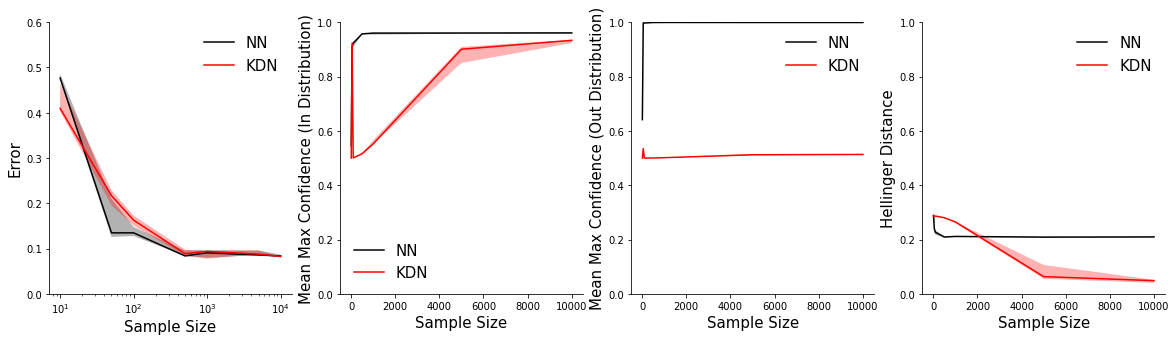

In [62]:
# plot the curves (without errorbars)
sample_size = [10, 50, 100, 500, 1000, 5000, 10000]
metrics = ["acc", "mmcIn", "mmcOut", "hd"]
names = ["nn", "kdn"]
colors = ["k", "r"]
labels = ["NN", "KDN"]
fig3, axes = plt.subplots(1, 4, figsize=(20, 5))
for k, metric in enumerate(metrics):
    ax = axes[k]
    for i, name in enumerate(names):
        param_med = []
        param_25_quantile = []
        param_75_quantile = []

        for sample in sample_size:
            if metric == "acc":
                param = 1 - np.array(ddf[name + "_" + metric])[np.array(ddf["sample"]) == sample]
            else:
                param = np.array(ddf[name + "_" + metric])[np.array(ddf["sample"]) == sample]
            s1, s2, s3 = compute_stats(param)
            param_med.append(s1)
            param_25_quantile.append(s2)
            param_75_quantile.append(s3)

        ax.plot(sample_size, param_med, c=colors[i], label=labels[i])
        ax.fill_between(
            sample_size, param_25_quantile, param_75_quantile, facecolor= colors[i], alpha=0.3
        )
        
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

    if metric == "acc":
        ax.set_xscale("log")
        ax.set_ylim([0, 0.6])
        ax.set_ylabel("Error", fontsize=15)
    if metric == "mmcIn":
        ax.set_ylim([0, 1])
        ax.set_ylabel("Mean Max Confidence (In Distribution)", fontsize=15)    
    if metric == "mmcOut":
        ax.set_ylim([0, 1])
        ax.set_ylabel("Mean Max Confidence (Out Distribution)", fontsize=15) 
    if metric == "hd":
        ax.set_ylim([0, 1])
        ax.set_ylabel("Hellinger Distance", fontsize=15) 
    ax.set_xlabel("Sample Size", fontsize=15)
    ax.legend(frameon=False, fontsize=15)
    

### OOD Detection Metrics

In [63]:
def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [64]:
sample_size = [10000]
reps = 5
n_test = 1000
true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

roc_nn = []
roc_kdn = []

fpr_nn = []
fpr_kdn = []

for ii in range(reps):
    X, y = generate_data(sample)
    X_test, y_test = generate_data(n_test)
    X_ood = generate_ood_samples(n_test)

    # train Vanilla NN
    nn = getNN()
    nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

    nn_in_conf = np.max(nn.predict(X_test), axis=1)
    nn_out_conf = np.max(nn.predict(X_ood), axis=1)
    nn_conf = np.hstack((nn_in_conf, nn_out_conf))
    roc_nn.append(
        roc_auc_score(true_labels, nn_conf)
    )
    fpr_nn.append(
        fpr_at_95_tpr(nn_in_conf, nn_out_conf)
    )
    
    # train KDN1
    if selectKDN == 1:
        model_kdn = kdn1(nn, **kdn1_kwargs)
    if selectKDN == 2:
        model_kdn = kdn2(nn, **kdn2_kwargs)
    if selectKDN == 3:
        model_kdn = kdn3(nn, **kdn3_kwargs)
    model_kdn.fit(X, y)

    kdn_in_conf = np.max(model_kdn.predict_proba(X_test), axis=1)
    kdn_out_conf = np.max(model_kdn.predict_proba(X_ood), axis=1)
    kdn_conf = np.hstack((kdn_in_conf, kdn_out_conf))
    roc_kdn.append(
        roc_auc_score(true_labels, kdn_conf)
    )
    fpr_kdn.append(
        fpr_at_95_tpr(kdn_in_conf, kdn_out_conf)
    )

    reps_list.append(ii)

ddf["kdn_roc"] = roc_kdn
ddf["nn_roc"] = roc_nn

ddf["kdn_fpr"] = fpr_kdn
ddf["nn_fpr"] = fpr_nn

In [65]:
# obtain the AUROC and FPR@95 scores

# AUROC
print("KDN AUROC = {:.3f} +/- {:.3f}".format(np.mean(ddf["kdn_roc"]), np.std(ddf["kdn_roc"])))
print("NN AUROC = {:.3f} +/- {:.3f}".format(np.mean(ddf["nn_roc"]), np.std(ddf["nn_roc"])))

KDN AUROC = 0.987 +/- 0.003
NN AUROC = 0.015 +/- 0.003


In [66]:
# FPR@95
print("KDN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(ddf["kdn_fpr"]), np.std(ddf["kdn_fpr"])))
print("NN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(ddf["nn_fpr"]), np.std(ddf["nn_fpr"])))

KDN FPR@95 = 0.338 +/- 0.306
NN FPR@95 = 0.865 +/- 0.135


### Save the Results

In [67]:
name = kdn_versions[selectKDN-1]
filename = "results/" + name + "_plot_data.mat"
savemat(filename, df)
filename = "results/" + name + "_experiment_data.mat"
savemat(filename, ddf)

In [68]:
filename = "plots/" + name + "_class_posteriors.pdf"
fig1.savefig(filename, bbox_inches='tight')
filename = "plots/" + name + "_class_likelihoods.pdf"
fig2.savefig(filename, bbox_inches='tight')
filename = "plots/" + name + "_results_plots.pdf"
fig3.savefig(filename, bbox_inches='tight')

### Test

In [ ]:
# for ii in range(5):
#     X, y = generate_data(sample)
#     X_test, y_test = generate_data(n_test)
#     X_ood = generate_ood_samples(n_test)

#     # train Vanilla NN
#     nn = getNN()
#     nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

#     proba_nn = nn.predict(grid_samples)
#     proba_nn = np.flip(proba_nn[:, 0].reshape(200, 200), axis=1)
    
#     # train KDN1
#     model_kdn = kdn1(nn, **kdn1_kwargs)     
#     model_kdn.fit(X, y)
#     proba_kdn1 = model_kdn.predict_proba(grid_samples)
#     proba_kdn1 = np.flip(proba_kdn1[:, 0].reshape(200, 200), axis=1)

#     # train KDN2
#     model_kdn = kdn2(nn, **kdn2_kwargs)
#     model_kdn.fit(X, y)
#     proba_kdn2 = model_kdn.predict_proba(grid_samples)
#     proba_kdn2 = np.flip(proba_kdn2[:, 0].reshape(200, 200), axis=1)

#     fig, ax = plt.subplots(1, 3, figsize=(30, 90))

#     ax0 = ax[0].imshow(
#         proba_nn,
#         extent=[xx.min(), xx.max(), yy.min(), yy.max()],
#         cmap="bwr",
#         vmin=0,
#         vmax=1,
#         interpolation="nearest",
#         aspect="auto",
#     )
#     ax[0].set_title("NN Class Posteriors", fontsize=24)
#     ax[0].set_aspect("equal")

#     ax1 = ax[1].imshow(
#         proba_kdn1,
#         extent=[xx.min(), xx.max(), yy.min(), yy.max()],
#         cmap="bwr",
#         vmin=0,
#         vmax=1,
#         interpolation="nearest",
#         aspect="auto",
#     )
#     ax[1].set_title("KDN approx lin Class Posteriors", fontsize=24)
#     ax[1].set_aspect("equal")
#     # fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)

#     ax2 = ax[2].imshow(
#         proba_kdn2,
#         extent=[xx.min(), xx.max(), yy.min(), yy.max()],
#         cmap="bwr",
#         vmin=0,
#         vmax=1,
#         interpolation="nearest",
#         aspect="auto",
#     )
#     ax[2].set_title("KDN strict lin Class Posteriors", fontsize=24)
#     ax[2].set_aspect("equal")
#     # fig.colorbar(ax2, ax=ax[2], fraction=0.046, pad=0.04)

#     plt.show()